In [87]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import copy
from tqdm import trange
from collections import deque
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt


In [88]:
class Map:
    def __init__(self, blocks_num, random_seed) -> None:
        self.size = np.array([100, 100, 100])
        self.dsize = 1 / self.size
        self.dagsize = 1 / np.linalg.norm(self.size)
        self.random_seed = random_seed
        self.blocks_num = blocks_num
        self.point_size = 2
        self.init_size = self.point_size * 5
        self._random_map(random_seed)
        return

    def _random_map(self, random_seed) -> None:
        np.random.seed(random_seed)
        self.drift = np.random.rand(3)*2-1
        self.drift = self.drift/np.linalg.norm(self.drift) *0.4

        self.blocks = np.zeros((self.blocks_num, 3))
        self.BEGIN = np.random.rand(3) * self.size
        self.END = np.random.rand(3) * self.size

        i = 0
        while i < self.blocks_num:
            point = np.random.rand(3) * self.size
            fitted = True
            d1 = np.linalg.norm(point-self.BEGIN)
            d2 = np.linalg.norm(point-self.END)
            if d1 <= self.init_size or d2 <= self.init_size:
                fitted = False

            for j in range(i):
                d = np.linalg.norm(point-self.blocks[j])
                if d <= self.init_size:
                    fitted = False

            if fitted:
                self.blocks[i] = point
                i += 1

        self.vd_blocks = self.blocks.flatten()
        return
    
    def reRandom(self):
        fitted = False
        while not fitted:
            fitted = True
            self.BEGIN = np.random.rand(3) * self.size
            if np.min(np.linalg.norm(self.blocks - self.BEGIN, axis=1)) <= self.init_size:
                fitted = False
        
        fitted = False
        while not fitted:
            fitted = True
            self.END = np.random.rand(3) * self.size
            if np.linalg.norm(self.END - self.BEGIN) <= self.init_size:
                fitted = False
            if np.min(np.linalg.norm(self.blocks - self.END, axis=1)) <= self.init_size:
                fitted = False

        return

In [89]:
class Agent:
    pos = np.zeros(3)
    vel = np.zeros(3)

    def __init__(self, Map) -> None:
        self.map = Map
        self.max_step = 500
        self.reset()
        return

    def reset(self) -> None:
        self.pos = self.map.BEGIN.copy()
        self.vel = np.zeros(3)
        self.steps = 0
        self.old_pos = self.pos.copy()
        self.old_vel = np.zeros(3)
        return

    def step(self, act):
        # 保存旧状态
        self.old_vel = self.vel.copy()
        self.old_pos = self.pos.copy()
        
        # 方向和力度
        dir = R.from_euler('zyx', np.array([np.pi*act[1], np.pi*0.5*act[2], 0])).apply(np.array([1, 0, 0]))
        f = act[0] + 1
        self.vel = dir * f *0.2 + self.vel *0.8
        self.pos += self.vel - (np.random.rand(3) *2-1) *0.01 + self.map.drift

        target = np.linalg.norm(self.map.END - self.pos)
        R1 = - target *self.map.dagsize

        R2 = f *-0.001

        R3 = 0
        arrive = False
        if target <= self.map.point_size:
            R3 = 10
            arrive = True

        min_dis = np.min(np.linalg.norm(self.map.blocks - self.pos, axis=1))
        R4 = min_dis *self.map.dagsize *0.002
        if min_dis <= self.map.point_size:
            R4 -= 10
            
        if (self.pos < 0).any() or (self.pos > self.map.size).any():
            R4 -= 0.1
            self.pos = self.old_pos.copy()
            self.vel = self.old_vel.copy()

        return R1+R2+R3+R4, arrive, min_dis
    
    def get_state(self):
        tmp = np.multiply(self.map.blocks, self.map.dsize)
        np.random.shuffle(tmp)
        return np.concatenate((
            tmp.flatten(),
            self.map.drift,
            self.pos *self.map.dsize,
            self.vel *self.map.dsize,
            self.old_pos *self.map.dsize,
            self.old_vel *self.map.dsize,
            self.map.END *self.map.dsize
        ))

In [90]:
class Actor_Net(nn.Module):
    def __init__(self, dim):
        super(Actor_Net, self).__init__()
        self.liner1 = nn.Linear(dim, 512)
        self.liner2 = nn.Linear(512, 512)
        self.liner3 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(self.liner1(x))
        x = F.relu(self.liner2(x))
        return torch.tanh(self.liner3(x))

In [100]:
blocks_num = 20
np.random.seed(312)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
actor_net = torch.load('actor_net160000.pt', map_location=device)

100%|██████████| 500/500 [00:00<00:00, 1952.73it/s]


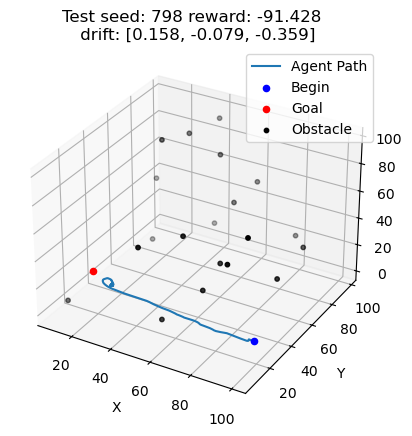

In [102]:
seed = np.random.randint(1,1000)
AMap = Map(blocks_num, seed)
agent = Agent(AMap)

agent.reset()
episode_reward = 0

positions = [agent.pos.copy()]

for step in trange(agent.max_step):
    state1 = agent.get_state()

    act = actor_net(torch.FloatTensor(state1).to(device))
    act = act.cpu().detach().numpy()
    if np.random.random() < 0.2:
        act = act * 0.5 + (np.random.rand(3)*2-1) * 0.5
    reward, arrive, min_dis = agent.step(act)
    state2 = agent.get_state()

    episode_reward += reward
    positions.append(agent.pos.copy())  # 存储位置
    # print(reward)

positions = np.array(positions)

# 绘制智能体路径
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Agent Path')
ax.scatter(agent.map.BEGIN[0], agent.map.BEGIN[1], agent.map.BEGIN[2], color='b', label='Begin', s=20)
ax.scatter(agent.map.END[0], agent.map.END[1], agent.map.END[2], color='r', label='Goal', s=20)
ax.scatter(agent.map.blocks[:, 0], agent.map.blocks[:, 1], agent.map.blocks[:, 2], color='k', label='Obstacle', s=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.title('Test seed: {} reward: {:.3f} \n drift: [{:.3f}, {:.3f}, {:.3f}]'.format(seed,
                                                                           episode_reward,
                                                                           agent.map.drift[0],
                                                                           agent.map.drift[1],
                                                                           agent.map.drift[2]))
plt.savefig(f'./test.png')



In [93]:
rewards=np.load('rewards.npy')
floss=np.load('floss.npy')
first=np.load('first.npy')
min_d=np.load('min_d.npy')
min_d_avg=np.load('min_d_avg.npy')
vel_avg=np.load('vel_avg.npy')

def moving_average(x, w):
    return np.convolve(x, np.ones(w)/w, "valid")

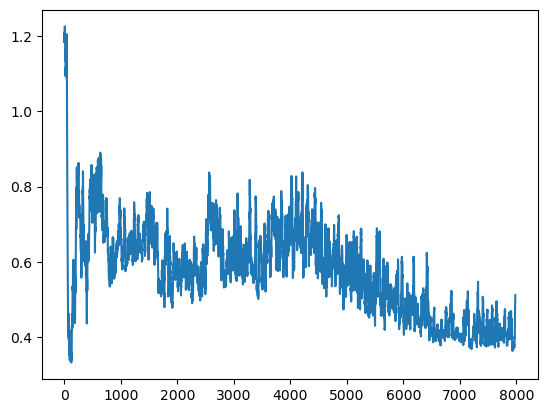

In [94]:
plt.plot(moving_average(vel_avg, 20))